In [1]:
!pip install --upgrade pip
!pip install mediapipe-model-maker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.5/117.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 22.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 54.4 

In [2]:
from google.colab import files
from google.colab import drive
import os
import random
import pathlib
import numpy as np
from numpy.random import seed
from PIL import Image

import tensorflow as tf
assert tf.__version__.startswith('2')

from mediapipe_model_maker import image_classifier

import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
%%capture
drive.mount('/content/gdrive', force_remount=True)
!tar --extract --verbose --file='/content/gdrive/MyDrive/Oxford_102/train.tar'
!tar --extract --verbose --file='/content/gdrive/MyDrive/Oxford_102/valid.tar'
!tar --extract --verbose --file='/content/gdrive/MyDrive/Oxford_102/test.tar'

In [4]:
def analyze_oxford_flowers_dataset(train_dir, valid_dir, test_dir):
    train_counts = []
    valid_counts = []
    test_counts = []

    for class_folder in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_folder)
        train_counts.append(len(os.listdir(class_path)))

    for class_folder in os.listdir(valid_dir):
        class_path = os.path.join(valid_dir, class_folder)
        valid_counts.append(len(os.listdir(class_path)))

    for class_folder in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_folder)
        test_counts.append(len(os.listdir(class_path)))

    # Calcola il numero massimo di immagini in una classe per train, valid e test
    max_train_count = max(train_counts)
    max_valid_count = max(valid_counts)
    max_test_count = max(test_counts)
  
    # Crea i grafici relativi al numero di immagini per classe
    fig, axs = plt.subplots(3, figsize=(8, 12))

    axs[0].bar(range(len(train_counts)), train_counts)
    axs[0].set_title('Numero di immagini per classe (train)')
    axs[0].set_xlabel('Classe')
    axs[0].set_ylabel('Numero di immagini')

    axs[1].bar(range(len(valid_counts)), valid_counts)
    axs[1].set_title('Numero di immagini per classe (valid)')
    axs[1].set_xlabel('Classe')
    axs[1].set_ylabel('Numero di immagini')

    axs[2].bar(range(len(test_counts)), test_counts)
    axs[2].set_title('Numero di immagini per classe (test)')
    axs[2].set_xlabel('Classe')
    axs[2].set_ylabel('Numero di immagini')

    plt.tight_layout()
    plt.show()

    # Stampa il numero massimo di immagini in una classe per train, valid e test
    print(f"Numero massimo di immagini in una classe (train): {max_train_count}")
    print(f"Numero massimo di immagini in una classe (valid): {max_valid_count}")
    print(f"Numero massimo di immagini in una classe (test): {max_test_count}")

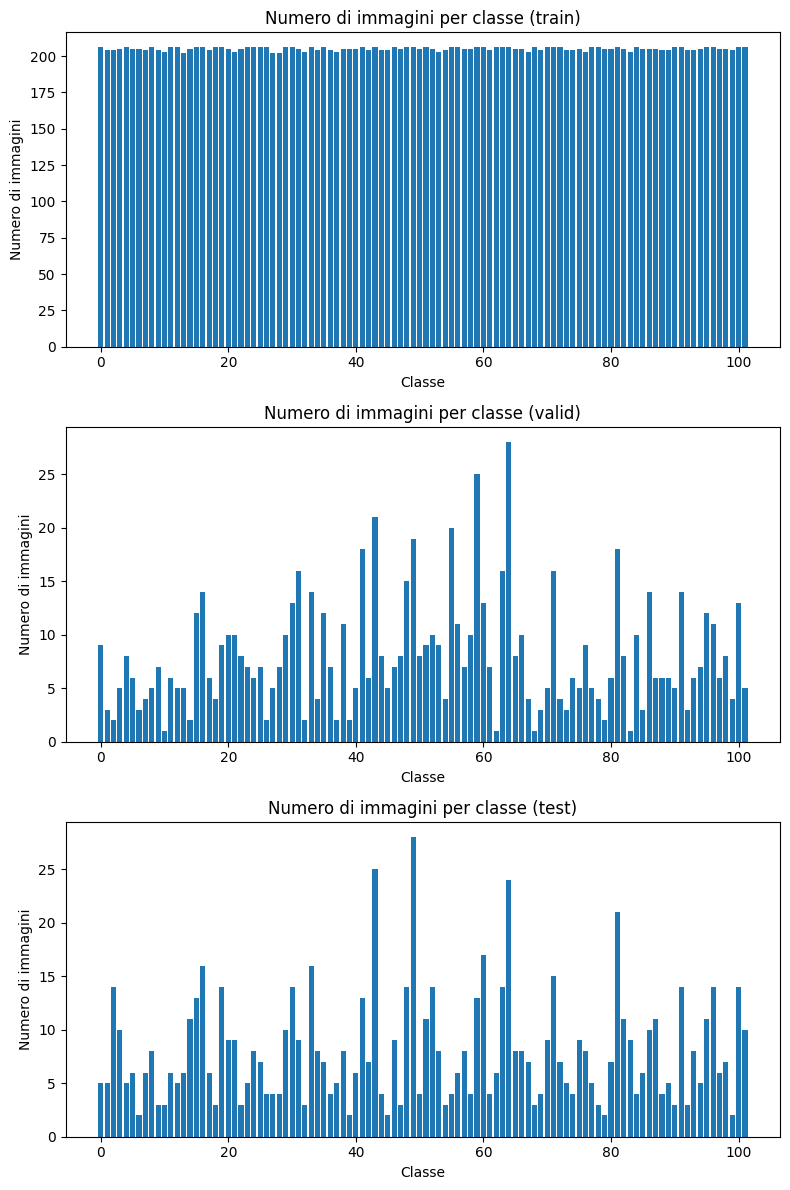

Numero massimo di immagini in una classe (train): 206
Numero massimo di immagini in una classe (valid): 28
Numero massimo di immagini in una classe (test): 28


In [5]:
train_dir = 'train/'
valid_dir = 'valid/'
test_dir = 'test/'
analyze_oxford_flowers_dataset(train_dir, valid_dir, test_dir)

In [6]:
train_data_dir = pathlib.Path('train/')
val_data_dir = pathlib.Path('valid/')
test_data_dir = pathlib.Path('test/')

In [7]:
train_data = image_classifier.Dataset.from_folder(train_data_dir)
val_data = image_classifier.Dataset.from_folder(val_data_dir)
test_data = image_classifier.Dataset.from_folder(test_data_dir)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
spec = image_classifier.SupportedModels.EFFICIENTNET_LITE0
hparams = image_classifier.HParams(export_dir="exported_model", epochs=50, batch_size=16)
options = image_classifier.ImageClassifierOptions(supported_model=spec, hparams=hparams)

In [9]:
model = image_classifier.ImageClassifier.create(
    train_data = train_data,
    validation_data = val_data,
    options=options,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              3413024   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 3,543,686
Trainable params: 130,662
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/50
1306/1306 [==============================] - 96s 64ms/step - loss: 4.4768 - accuracy: 0.0747 - val_loss: 3.7495 - val_accuracy: 0.3460
Epoch 2/50
1306/1306 [==============================] - 77s 59ms/step - loss: 3.0663 - accuracy: 0.5132 - val_loss: 2.3092 - val_accuracy: 0.7628
Epoch 3

In [10]:
model.export_model()

In [11]:
!ls exported_model
files.download('exported_model/model.tflite')

checkpoint  metadata.json  model.tflite  summaries


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
_, acc = model.evaluate(test_data)
print('Test accuracy: %f' % acc)

26/26 [==============================] - 4s 121ms/step - loss: 1.4084 - accuracy: 0.9426
Test accuracy: 0.942613
